## Preparing the environment

In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.6 MB/s 
     |████████████████████████████████| 67 kB 3.5 MB/s 
     |████████████████████████████████| 6.5 MB 33.3 MB/s 
     |████████████████████████████████| 596 kB 33.6 MB/s 
     |████████████████████████████████| 895 kB 37.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc # garbage collections
import bz2 # to open zipped files
import tensorflow as tf
from tensorflow import keras
from keras import models, layers

## Loading the Dataset

In [3]:
! pip install kaggle 
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d bittlingmayer/amazonreviews
! unzip /content/amazonreviews.zip -d /content/amazonreviews

 98% 482M/493M [00:04<00:00, 95.7MB/s]
100% 493M/493M [00:04<00:00, 109MB/s] 
Archive:  /content/amazonreviews.zip
  inflating: /content/amazonreviews/test.ft.txt.bz2  
  inflating: /content/amazonreviews/train.ft.txt.bz2  


In [4]:
# read the files
train = bz2.BZ2File('/content/amazonreviews/train.ft.txt.bz2')
test = bz2.BZ2File('/content/amazonreviews/test.ft.txt.bz2')

train = train.readlines()
test = test.readlines()

# convert from raw binary strings into text files that can be parsed
train = [x.decode('utf-8') for x in train]
test = [x.decode('utf-8') for x in test]

# extract the labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train] 
test_labels = [0 if x.split(' ')[0] =='__label__1' else 1 for x in test]

# extract the texts
train_texts = [x.split(' ', maxsplit=1)[1][:-1] for x in train]
test_texts = [x.split(' ', maxsplit=1)[1][:-1] for x in test]

In [5]:
del train, test

gc.collect()

72

## Implementing a Transformer with Keras

In [ ]:
# let's tokenize and vectorize the dataset
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open('/content/drive/MyDrive/ML Models/tokenizer.pickle', 'rb') as handle:
   tokenizer = pickle.load(handle)

In [ ]:
sequences = tokenizer.texts_to_sequences(train_texts)
maxlen = 100
# pad the sequences
sequences = pad_sequences(sequences, maxlen=maxlen)

# let's convert the labels to numpy arrays
labels = np.array(train_labels)

In [ ]:
# let's reduce the dataset size

indices = np.arange(len(train_texts))
np.random.shuffle(indices)
train_data = sequences[indices]
train_labels = labels[indices]

train_size = 400000
train_data = train_data[:train_size]
train_labels = train_labels[:train_size]

In [ ]:
# let's do the same to the test dataset
test_labels = np.array(test_labels)

test = tokenizer.texts_to_sequences(test_texts)
test = pad_sequences(test, maxlen=maxlen)

# let's reduce the dataset size
indices = np.arange(len(test_texts))
np.random.shuffle(indices)
test = test[indices]
test_labels = test_labels[indices]

test_size = 40000
test = test[:test_size]
test_labels = test_labels[:test_size]

In [ ]:
# create the transformer block

class TransformerBlock(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential([layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),])
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

# implement the embedding layer

class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim = embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

In [ ]:
# parameters for training
embed_dim = 32
num_heads = 2
ff_dim = 32
vocab_size = 70000

# create the model
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs = outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddin  (None, 100, 32)          2243200   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 100, 32)          10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
             keras.callbacks.ModelCheckpoint('transformer.h5', save_best_only=True)]

history = model.fit(train_data, train_labels, epochs=20, validation_split=0.2)

Epoch 1/20
10000/10000 [==============================] - 119s 11ms/step - loss: 0.2836 - accuracy: 0.8813 - val_loss: 0.2632 - val_accuracy: 0.8892
Epoch 2/20
10000/10000 [==============================] - 114s 11ms/step - loss: 0.2321 - accuracy: 0.9049 - val_loss: 0.2679 - val_accuracy: 0.8922
Epoch 3/20
10000/10000 [==============================] - 109s 11ms/step - loss: 0.2083 - accuracy: 0.9141 - val_loss: 0.2667 - val_accuracy: 0.8941
Epoch 4/20
10000/10000 [==============================] - 112s 11ms/step - loss: 0.1846 - accuracy: 0.9236 - val_loss: 0.2960 - val_accuracy: 0.8934
Epoch 5/20
10000/10000 [==============================] - 110s 11ms/step - loss: 0.1620 - accuracy: 0.9329 - val_loss: 0.3106 - val_accuracy: 0.8904
Epoch 6/20
10000/10000 [==============================] - 107s 11ms/step - loss: 0.1402 - accuracy: 0.9425 - val_loss: 0.3662 - val_accuracy: 0.8856
Epoch 7/20
10000/10000 [==============================] - 107s 11ms/step - loss: 0.1199 - accuracy: 0.9521

In [ ]:
def learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Train Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Train Accuracy')
    plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()

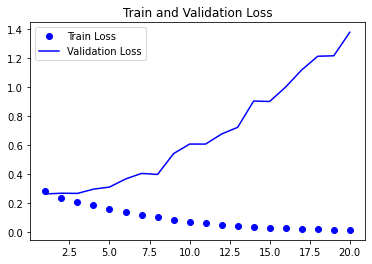

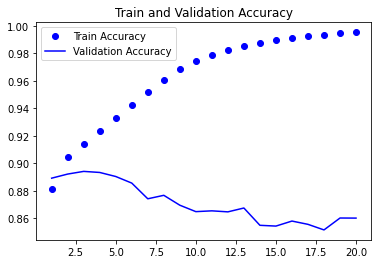

In [ ]:
learning_curve(history)

In [ ]:
loss, acc = model.evaluate(test, test_labels)
loss, acc

1250/1250 [==============================] - 5s 4ms/step - loss: 1.3400 - accuracy: 0.8622


(1.3400139808654785, 0.8621500134468079)

In [ ]:
del test, test_labels, train_data, train_labels, sequences

gc.collect()

8002

In [ ]:
del train_texts, test_texts

gc.collect()

0